# Logistic regression for spam classification

This notebooks corresponds to the experiments of Section 6.3 of the supplementary materials

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.distributions import MultivariateNormal
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from src.numpyro_log_reg import LogisticRegression
from src.weights_optimizer import WeightsOptimizer

from src.utils import to_np, to_tensor
from tqdm import tqdm

import seaborn as sns

# Prepare the data

In [3]:
filepath = "../../data/SMSSpamCollection"

In [4]:
dataset = pd.read_csv(filepath, sep="\t", header=None)
dataset.columns = ["label", "text"]
dataset["label"] = dataset["label"] == "spam"
dataset

,label,text
0,False,"Go until jurong point, crazy.. Available only ..."
1,False,Ok lar... Joking wif u oni...
2,True,Free entry in 2 a wkly comp to win FA Cup fina...
3,False,U dun say so early hor... U c already then say...
4,False,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,True,This is the 2nd time we have tried 2 contact u...
5568,False,Will ü b going to esplanade fr home?
5569,False,"Pity, * was in mood for that. So...any other s..."
5570,False,The guy did some bitching but I acted like i'd...


## Remove the duplicates

The original dataset contains duplicates, we remove them before performinf the experiments

In [ ]:
dct = {}
to_keep = np.ones(len(dataset), dtype="bool")
for i in dataset.text.index:
    if dataset.text[i] not in dct:
        dct[dataset.text[i]] = dataset.label[i]
    else:
        to_keep[i] = False

for i in dataset.text.index:
    if "message:some text missing*" in dataset.text[i].lower():
        to_keep[i] = False

# Separate the dataset into spam and ham
spam = dataset[np.logical_and(to_keep, dataset["label"] == True)]
ham = dataset[np.logical_and(to_keep, dataset["label"] == False)]

# Balance the dataset by downsampling the majority class
min_samples = min(len(spam), len(ham))

spam_downsampled = resample(spam, replace=False, n_samples=min_samples, random_state=42)
ham_downsampled = resample(ham, replace=False, n_samples=min_samples, random_state=42)

balanced_dataset = pd.concat([spam_downsampled, ham_downsampled])

# Train/test split
train_dataset, test_dataset = train_test_split(balanced_dataset, random_state=42)

train_dataset = train_dataset.reset_index(drop=True)#train_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)


In [ ]:
train_dataset

,label,text
0,False,Hey are you angry with me. Reply me dr.
1,True,Free video camera phones with Half Price line ...
2,True,network operator. The service is free. For T &...
3,True,Free Msg: Ringtone!From: http://tms. widelive....
4,False,"Hi hope u get this txt~journey hasnt been gd,n..."
...,...,...
974,False,Then any special there?
975,False,Heehee that was so funny tho
976,False,Hey what how about your project. Started aha da.
977,False,"SHIT BABE.. THASA BIT MESSED UP.YEH, SHE SHUDV..."


### Preprocess texts as binary vectors

In [ ]:
vectorizer = CountVectorizer(strip_accents="unicode", binary=True, min_df=50)

bin_vectors_train = vectorizer.fit_transform(train_dataset["text"]).todense().A
bin_vectors_test = vectorizer.transform(test_dataset["text"]).todense().A

print(bin_vectors_train.shape)

num_words = bin_vectors_train.shape[1]

(979, 48)


In [ ]:
vocabulary = vectorizer.get_feature_names_out()

In [ ]:
X = torch.tensor(bin_vectors_train, dtype=torch.float)
y = torch.tensor(train_dataset["label"], dtype=torch.float)

data = {"X":X, "y":y}

prior_parameters = {"mu": torch.zeros(num_words, dtype=torch.float), "Sigma": torch.eye(num_words, dtype=torch.float)*100}
model = LogisticRegression(prior_parameters)
samples_orig = model.sample_posterior(5000, data, warmup_steps=100)
mean_post, cov_post = model.normal_posterior_approximation(data, lr=2e-1, verbose=1, optim_steps=1000)
origi_post_approx = MultivariateNormal(mean_post, cov_post)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


100%|██████████| 1000/1000 [00:00<00:00, 1614.05it/s, init loss: 1139.7727, avg. loss [951-1000]: 423.8812]


In [ ]:
X.shape, y.shape

(torch.Size([979, 48]), torch.Size([979]))

### Model performances

In [ ]:
# Bayesian predictions using MCMC
train_logits = torch.tensor(bin_vectors_train, dtype=torch.float32) @ samples_orig["beta"].T
y_pred_train = torch.nn.functional.sigmoid(train_logits).mean(1) > 0.5
print("Train accuracy:", "%.3f" % to_np((y == y_pred_train).float().mean()))


test_logits = torch.tensor(bin_vectors_test, dtype=torch.float32) @ samples_orig["beta"].T
y_pred_test = torch.nn.functional.sigmoid(test_logits).mean(1) > 0.5
print("Test accuracy:", "%.3f" % to_np((torch.tensor(test_dataset["label"]) == y_pred_test).float().mean()))

Train accuracy: 0.911
Test accuracy: 0.859


## Find a target word

Criterion: 
- a word with enough occurences in the dataset with both labels (not present just for spam)
- The probability of the parameter being negative is low

In [17]:
mean = samples_orig["beta"].mean(0).data
std = samples_orig["beta"].std(0).data

prob_neg = torch.mean((samples_orig["beta"] < 0).float(), dim=0)

occurences_in_ham = np.sum(bin_vectors_train.T * (1-np.array(train_dataset["label"]).astype(float)), axis=1).reshape(-1, 1)
occurences_in_spam = np.sum(bin_vectors_train.T * np.array(train_dataset["label"]).astype(float), axis=1).reshape(-1, 1)

min_occurence_label = np.min(np.concatenate((occurences_in_ham, occurences_in_spam), axis=1), axis=1)

idx = torch.argsort(torch.abs(mean)/std, descending=True)

In [18]:
for i in idx:
    if prob_neg[i] < 0.05 and min_occurence_label[i] > 10:
        print(vocabulary[i], mean[i].data.numpy(), std[i].data.numpy(), prob_neg[i].data.numpy(), min_occurence_label[i])

call 2.8198872 0.41268033 0.0 29.0
for 1.0309325 0.40073463 0.003 41.0
from 1.3716422 0.544799 0.0048 15.0
your 1.0090729 0.4181239 0.0062 30.0
with 0.985287 0.54657775 0.0364 22.0


## Define target

In [24]:
target_word = "your"
id_word = list(vocabulary).index(target_word)
print("mean:", float(mean[id_word]), "std:", float(std[id_word]))

mean: 1.0090728998184204 std: 0.41812390089035034


In [25]:
mean_A = mean_post.clone()
mean_A[id_word] = -mean_A[id_word]
cov_A = cov_post
adv_target_dist = MultivariateNormal(mean_A, cov_A)
sample_adv = lambda n_param_samples: {"beta": adv_target_dist.sample((n_param_samples, ))}
mean_post[id_word]

tensor(0.9176)

## Perform attacks

Rounding kl difference: 2.0921597
L1 before rounding: 20.0
L1 after rounding: 17.0


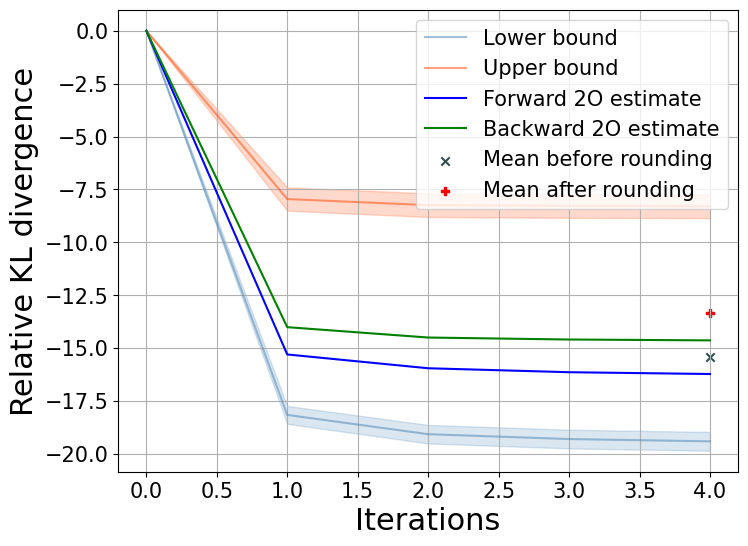

In [27]:
max_L1 = 20
max_occurence = 2
model.seed = 0
torch.manual_seed(0)
optim = WeightsOptimizer(data, model, sample_adv)
weights = optim.optimize(n_MC_samples_adv=1000, n_MC_samples_post=200,
                         max_iterations=4, heuristic="2O-EMA-R2",
                         max_L1=max_L1, max_occurence=max_occurence, eps=1e-1,
                         betas=(0.5, ),
                         verbose=True,
                         make_plots=True)

In [28]:
results = {}
max_occurence = 2 
max_L1_list = [3, 6, 10, 15, 20, 25, 30, 40]
n_repeats = 5


params_FGSM = {"heuristic": "FGSM",
               "n_MC_samples_adv": 1000,
               "n_MC_samples_post": 1000,
               "max_iterations": None,
               "stopping_ratio": None,
               "betas": None,
               "eps": None,
               "lr": None
                }

params_2O_ISCD = {"heuristic": "2O-ISCD",
                 "n_MC_samples_adv": 1000,
                 "n_MC_samples_post": 500,
                 "max_iterations": 45,
                 "stopping_ratio": None,
                 "betas": None,
                 "eps": None,
                 "lr": None
                }

params_2O_R2 = {"heuristic": "2O-R2",
               "n_MC_samples_adv": 1000,
               "n_MC_samples_post": 500,
               "max_iterations": 5,
               "stopping_ratio": 1e-3,
               "betas": None,
               "eps": 1e0,
               "lr": None
                }



params_dicts_list = [params_FGSM, params_2O_ISCD, params_2O_R2]

In [29]:
model.seed = 0
torch.manual_seed(0)

for params_dict in params_dicts_list:

    print(params_dict["heuristic"])
    
    results_heuristic = {}
    
    for max_L1 in tqdm(max_L1_list):
            
        results_L1 = {  "weights": [], 
                        "L1": [], 
                        "mean": [], 
                        "cov": [],
                        "KLs": []}
        
        for i in range(n_repeats):
            

            opti = WeightsOptimizer(data, model, sample_adv)

            weights = opti.optimize(max_occurence=max_occurence, max_L1=max_L1,
                                            heuristic=params_dict["heuristic"],
                                            n_MC_samples_adv=params_dict["n_MC_samples_adv"],
                                            n_MC_samples_post=params_dict["n_MC_samples_post"],
                                            max_iterations=params_dict["max_iterations"],
                                            stopping_ratio=params_dict["stopping_ratio"],
                                            eps=params_dict["eps"],
                                            lr=params_dict["lr"],
                                            verbose=False, 
                                            make_plots=False)
            
            mean, cov = model.normal_posterior_approximation(data, weights=weights, method="Laplace", optim_steps=10000, lr=1e-1, verbose=False) 
            post_normal_approx = MultivariateNormal(mean, cov) 
            
            kl_est = float(kl_divergence(adv_target_dist, post_normal_approx)
.detach().numpy())

            results_L1["weights"].append(weights)
            L1 = float(torch.norm(torch.ones_like(weights, dtype=float) - weights, p=1))
            results_L1["L1"].append(L1)
            results_L1["mean"].append(mean)
            results_L1["cov"].append(cov)
            results_L1["KLs"].append(kl_est)
        
        # Store as tensors
        for key in results_L1.keys():
            results_L1[key] = to_tensor(results_L1[key])
        
        # Save the dictionary of results for this max_L1 value
        results_heuristic[max_L1] = results_L1

    # Save the dictionary of results for this heuristic
    results[params_dict["heuristic"]] = results_heuristic

FGSM


100%|██████████| 8/8 [02:15<00:00, 16.96s/it]


2O-ISCD


100%|██████████| 8/8 [32:23<00:00, 242.94s/it]


2O-R2


100%|██████████| 8/8 [13:59<00:00, 104.90s/it]


In [30]:
save_path = None # "../output/spam_classification/results_your_clean"
if save_path is not None:
    torch.save(results, save_path)

In [31]:
kl_divergence(adv_target_dist, origi_post_approx)

tensor(14.1475)

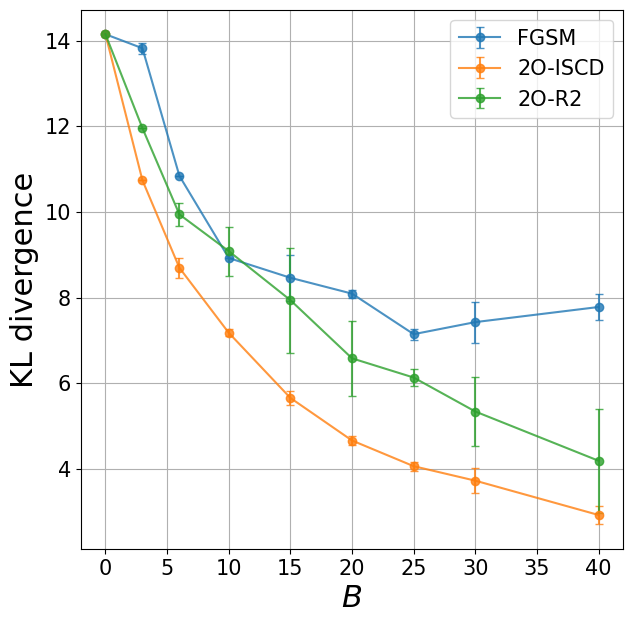

In [33]:
CLR_ORIGINAL = "Green"
CLR_TARGET = "Red"
CLR_TAINTED = "Blue"

colors = [CLR_ORIGINAL, CLR_TARGET, CLR_TAINTED]

AX_LBL_SIZE = 22
TICKS_LBL_SIZE = 15
LEGEND_LBL_SIZE = 15

error_bar_scale = 1.96
not_show = [] 
plt.figure(figsize=(7, 7))

original_KL = kl_divergence(adv_target_dist, origi_post_approx)

for heuristic in results.keys():
    if heuristic in not_show:
        continue
    results_heuristic = results[heuristic]
    KL_means = torch.zeros(len(results_heuristic)+1)
    KL_stds = torch.zeros(len(results_heuristic)+1)
    KL_means[0] = original_KL
    for i, max_L1 in enumerate(results_heuristic.keys()):
        KL_repeats = results_heuristic[max_L1]['KLs']
        KL_means[i+1] = KL_repeats.mean()
        KL_stds[i+1] = KL_repeats.std() / np.sqrt(len(KL_repeats))
    plt.errorbar([0] + list(results_heuristic.keys()), KL_means, yerr=KL_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)
    #plt.plot(results_heuristic.keys(), KL_means, alpha=0.6)
plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("KL divergence", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.show()


FGSM


8it [01:31, 11.46s/it]


2O-ISCD


8it [01:33, 11.70s/it]


2O-R2


8it [01:38, 12.34s/it]


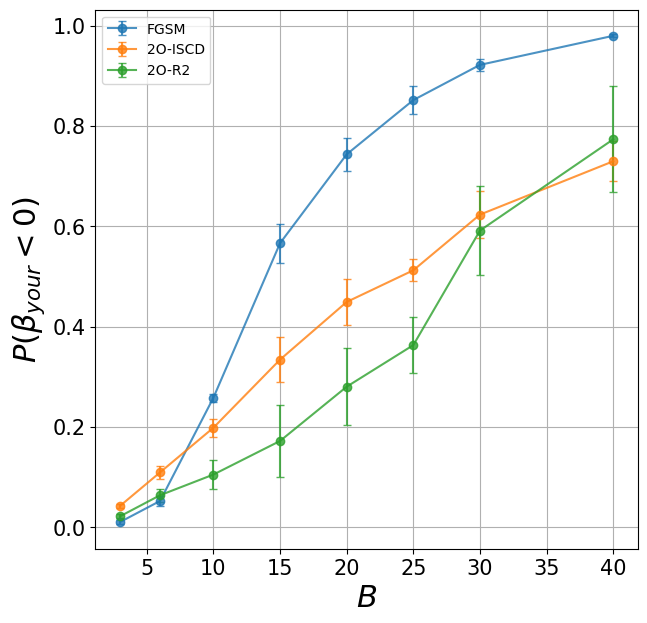

In [34]:
error_bar_scale = 1.96
threshold = torch.tensor([0.0])
n_samples_post = 1000

not_show = []

plt.figure(figsize=(7, 7))

for heuristic in results.keys():
    if heuristic in not_show:
        continue
    print(heuristic)
    results_heuristic = results[heuristic]
    prob_neg_means = torch.zeros(len(results_heuristic))
    prob_neg_stds = torch.zeros(len(results_heuristic))

    for i, max_L1 in tqdm(enumerate(results_heuristic.keys())):
        n = len(results_heuristic[max_L1]["weights"])
        prob_neg_repeats = torch.zeros(n)
        results_heuristic[max_L1]["MCMC_mean"] = torch.zeros(n)
        results_heuristic[max_L1]["MCMC_prob_neg"] = torch.zeros(n)

        for j in range(n):
            post_samples = model.sample_posterior(n_samples_post, data, weights=results_heuristic[max_L1]["weights"][j], warmup_steps=100)
            prob_neg = torch.mean((post_samples["beta"][:, id_word] < threshold).float())
            prob_neg_repeats[j] = prob_neg
            results_heuristic[max_L1]["MCMC_prob_neg"][j] = prob_neg
            results_heuristic[max_L1]["MCMC_mean"][j] = post_samples["beta"][:, id_word].mean()

        prob_neg_means[i] = prob_neg_repeats.mean()

        prob_neg_stds[i] = prob_neg_repeats.std() / np.sqrt(n)

    plt.errorbar(results_heuristic.keys(), prob_neg_means, yerr=prob_neg_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("$P(\\beta_{"+target_word+"}<0)$", fontsize=AX_LBL_SIZE)#$\mathbb{P}(\beta_{RM}<0)$
plt.grid(True)
plt.legend()
plt.show()

FGSM


8it [00:00, 6240.36it/s]


2O-ISCD


8it [00:00, 7286.52it/s]


2O-R2


8it [00:00, 7134.69it/s]


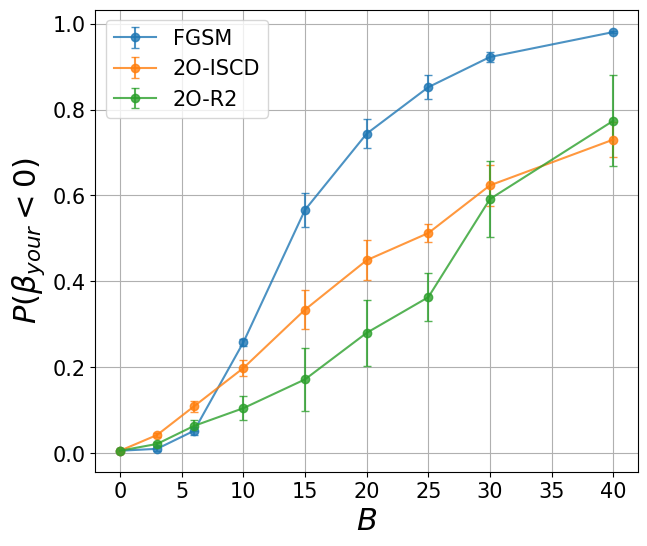

In [57]:
# From stored results

error_bar_scale = 1.96
threshold = torch.tensor([0.0])
not_show = []

plt.figure(figsize=(7, 6))

for heuristic in results.keys():
    if heuristic in not_show:
        continue
    print(heuristic)
    results_heuristic = results[heuristic]
    prob_neg_means = torch.zeros(len(results_heuristic)+1)
    prob_neg_stds = torch.zeros(len(results_heuristic)+1)
    
    # Initial value before attack:
    prob_neg_means[0] = (samples_orig["beta"][:, id_word] < 0).float().mean()

    for i, max_L1 in tqdm(enumerate(results_heuristic.keys())):
        n = len(results_heuristic[max_L1]["weights"])
        prob_neg_repeats = results_heuristic[max_L1]["MCMC_prob_neg"]

        prob_neg_means[i+1] = prob_neg_repeats.mean()

        prob_neg_stds[i+1] = prob_neg_repeats.std() / np.sqrt(n)


    plt.errorbar([0] + list(results_heuristic.keys()), 
                 prob_neg_means, yerr=prob_neg_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)


plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("$P(\\beta_{"+target_word+"}<0)$", fontsize=AX_LBL_SIZE)#$\mathbb{P}(\beta_{RM}<0)$plt.grid(True)
plt.grid(True)
plt.show()

FGSM


8it [00:00, 7348.76it/s]


2O-ISCD


8it [00:00, 7671.34it/s]


2O-R2


8it [00:00, 7687.16it/s]


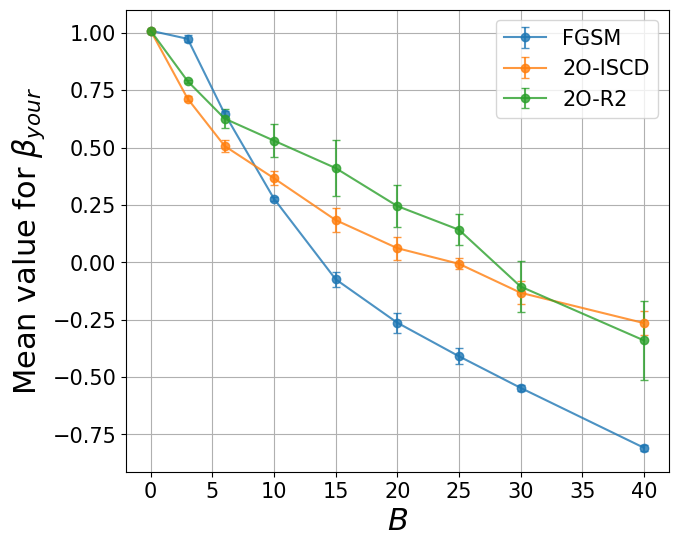

In [58]:
# From stored results

error_bar_scale = 1.96
threshold = torch.tensor([0.0])

not_show = []

plt.figure(figsize=(7, 6))

for heuristic in results.keys():
    if heuristic in not_show:
        continue
    print(heuristic)
    
    results_heuristic = results[heuristic]
    prob_neg_means = torch.zeros(len(results_heuristic)+1)
    prob_neg_stds = torch.zeros(len(results_heuristic)+1)

    prob_neg_means[0] = samples_orig["beta"][:, id_word].mean()

    for i, max_L1 in tqdm(enumerate(results_heuristic.keys())):
        n = len(results_heuristic[max_L1]["weights"])
        prob_neg_repeats = results_heuristic[max_L1]["MCMC_mean"]

        prob_neg_means[i+1] = prob_neg_repeats.mean()

        prob_neg_stds[i+1] = prob_neg_repeats.std() / np.sqrt(n)


    plt.errorbar([0] + list(results_heuristic.keys()), 
                 prob_neg_means, yerr=prob_neg_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("Mean value for $\\beta_{"+target_word+"}$", fontsize=AX_LBL_SIZE)
plt.grid(True)
#plt.yscale("log")
plt.show()

## Analyze perturbations

In [59]:
max_L1 = 15
weights = results["2O-R2"][max_L1]["weights"][-1]

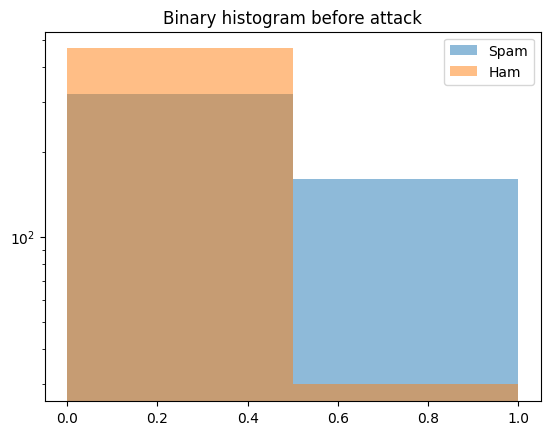

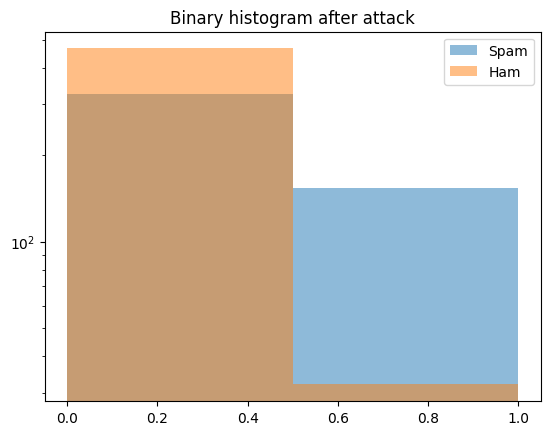

In [60]:
vectors_spam = bin_vectors_train[train_dataset["label"], id_word]
vectors_ham = bin_vectors_train[train_dataset["label"] == False, id_word]

plt.hist(vectors_spam, alpha=0.5, label="Spam", bins=2)
plt.hist(vectors_ham, alpha=0.5, label="Ham", bins=2)
plt.legend()
plt.yscale("log")
plt.title("Binary histogram before attack")
plt.show()

repeat_vectors = np.repeat(bin_vectors_train[:, id_word], weights)
repeat_labels = np.repeat(train_dataset["label"], weights)
vectors_spam = repeat_vectors[repeat_labels]
vectors_ham = repeat_vectors[repeat_labels == False]

plt.hist(vectors_spam, alpha=0.5, label="Spam", bins=2)
plt.hist(vectors_ham, alpha=0.5, label="Ham", bins=2)
plt.title("Binary histogram after attack")
plt.legend()
plt.yscale("log")
plt.show()

In [61]:
ham_with_word_before = np.sum((1 - train_dataset["label"]) * (bin_vectors_train[:, id_word] > 0))
spam_with_word_before = np.sum(train_dataset["label"] * (bin_vectors_train[:, id_word] > 0))
ham_without_word_before = np.sum((1 - train_dataset["label"]) * (bin_vectors_train[:, id_word] == 0))
spam_without_word_before = np.sum(train_dataset["label"] * (bin_vectors_train[:, id_word] == 0))

ham_with_word_after= int(np.sum((1 - train_dataset["label"]) * (bin_vectors_train[:, id_word] > 0) * weights.numpy()))
spam_with_word_after = int(np.sum(train_dataset["label"] * (bin_vectors_train[:, id_word] > 0) * weights.numpy()))
ham_without_word_after= int(np.sum((1 - train_dataset["label"]) * (bin_vectors_train[:, id_word] == 0) * weights.numpy()))
spam_without_word_after = int(np.sum(train_dataset["label"] * (bin_vectors_train[:, id_word] == 0) * weights.numpy()))

In [62]:
print("ham_with_word_before", ham_with_word_before)
print("spam_with_word_before", spam_with_word_before)
print("ham_without_word_before", ham_without_word_before)
print("spam_without_word_before", spam_without_word_before)
print()

print("ham_with_word_after", ham_with_word_after)
print("spam_with_word_after", spam_with_word_after)
print("ham_without_word_after", ham_without_word_after)
print("spam_without_word_after", spam_without_word_after)

ham_with_word_before 30
spam_with_word_before 161
ham_without_word_before 466
spam_without_word_before 322

ham_with_word_after 32
spam_with_word_after 153
ham_without_word_after 466
spam_without_word_after 323


In [63]:
ham_with_word_deleted = np.sum((1 - train_dataset["label"]) * (bin_vectors_train[:, id_word] > 0) * (weights.numpy() < 1))
spam_with_word_deleted = np.sum(train_dataset["label"] * (bin_vectors_train[:, id_word] > 0) * (weights.numpy() < 1))
ham_without_word_deleted = np.sum((1 - train_dataset["label"]) * (bin_vectors_train[:, id_word] == 0) * (weights.numpy() < 1))
spam_without_word_deleted = np.sum(train_dataset["label"] * (bin_vectors_train[:, id_word] == 0) * (weights.numpy() < 1))

ham_with_word_replicated = int(np.sum((1 - train_dataset["label"]) * (bin_vectors_train[:, id_word] > 0)  * (weights.numpy() > 1)))
spam_with_word_replicated = int(np.sum(train_dataset["label"] * (bin_vectors_train[:, id_word] > 0)  * (weights.numpy() > 1)))
ham_without_word_replicated= int(np.sum((1 - train_dataset["label"]) * (bin_vectors_train[:, id_word] == 0) * (weights.numpy() > 1)))
spam_without_word_replicated = int(np.sum(train_dataset["label"] * (bin_vectors_train[:, id_word] == 0) * (weights.numpy() > 1)))

In [64]:
print("ham_with_word_deleted", ham_with_word_deleted)
print("spam_with_word_deleted", spam_with_word_deleted)
print("ham_without_word_deleted", ham_without_word_deleted)
print("spam_without_word_deleted", spam_without_word_deleted)
print()

print("ham_with_word_replicated", ham_with_word_replicated)
print("spam_with_word_replicated", spam_with_word_replicated)
print("ham_without_word_replicated", ham_without_word_replicated)
print("spam_without_word_replicated", spam_without_word_replicated)

ham_with_word_deleted 0
spam_with_word_deleted 8
ham_without_word_deleted 0
spam_without_word_deleted 0

ham_with_word_replicated 2
spam_with_word_replicated 0
ham_without_word_replicated 0
spam_without_word_replicated 1


In [65]:
for i in range(len(weights)):
    sms = train_dataset["text"][i].lower()
    label = "SPAM" if train_dataset["label"][i] else "HAM"
    presence = "PRESENT" if target_word in sms else "ABSENT"
    if (bin_vectors_train[i, id_word] > 0) != (target_word in sms):
        if "yours" not in sms:
            print(presence, bin_vectors_train[i, id_word])
            print(sms)

PRESENT 0
uhhhhrmm isnt having tb test bad when youre sick
PRESENT 0
smsservices. for yourinclusive text credits, pls goto www.comuk.net login= 3qxj9 unsubscribe with stop, no extra charge. help 08702840625.comuk. 220-cm2 9ae


### Print duplicated texts

In [66]:
for i in range(len(weights)):
    if weights[i] > 1:
        sms = train_dataset["text"][i]
        label = "SPAM" if train_dataset["label"][i] else "HAM"
        print(label, bin_vectors_train[i, id_word] > 0, sms)

HAM True Sir, waiting for your letter.
SPAM False Would you like to see my XXX pics they are so hot they were nearly banned in the uk!
HAM True Also remember to get dobby's bowl from your car


### Print deleted texts

In [67]:
for i in range(len(weights)):
    if weights[i] < 1:
        sms = train_dataset["text"][i]
        label = "SPAM" if train_dataset["label"][i] else "HAM"
        print(label, bin_vectors_train[i, id_word] > 0, sms)

SPAM True RECPT 1/3. You have ordered a Ringtone. Your order is being processed...
SPAM True Check Out Choose Your Babe Videos @ sms.shsex.netUN fgkslpoPW fgkslpo
SPAM True Reminder: You have not downloaded the content you have already paid for. Goto http://doit. mymoby. tv/ to collect your content.
SPAM True ROMCAPspam Everyone around should be responding well to your presence since you are so warm and outgoing. You are bringing in a real breath of sunshine.
SPAM True 83039 62735=£450 UK Break AccommodationVouchers terms & conditions apply. 2 claim you mustprovide your claim number which is 15541 
SPAM True Wanna have a laugh? Try CHIT-CHAT on your mobile now! Logon by txting the word: CHAT and send it to No: 8883 CM PO Box 4217 London W1A 6ZF 16+ 118p/msg rcvd
SPAM True You will recieve your tone within the next 24hrs. For Terms and conditions please see Channel U Teletext Pg 750
SPAM True CALL 09090900040 & LISTEN TO EXTREME DIRTY LIVE CHAT GOING ON IN THE OFFICE RIGHT NOW TOTAL PRI

In [68]:
train_dataset["text"][(weights > 1).numpy()]

142                        Sir, waiting for your letter.
699    Would you like to see my XXX pics they are so ...
836      Also remember to get dobby's bowl from your car
Name: text, dtype: object

In [69]:
train_dataset["text"][(weights < 1).numpy()]

43     RECPT 1/3. You have ordered a Ringtone. Your o...
59     Check Out Choose Your Babe Videos @ sms.shsex....
73     Reminder: You have not downloaded the content ...
107    ROMCAPspam Everyone around should be respondin...
199    83039 62735=£450 UK Break AccommodationVoucher...
233    Wanna have a laugh? Try CHIT-CHAT on your mobi...
506    You will recieve your tone within the next 24h...
899    CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
Name: text, dtype: object

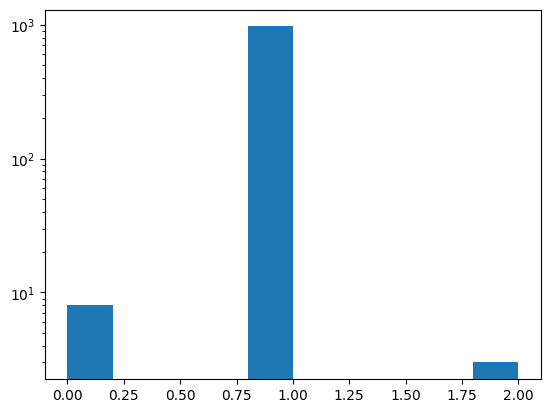

In [70]:
plt.hist(weights)
plt.yscale("log")
plt.show()

In [71]:
samples_tainted = model.sample_posterior(5000, data, weights=weights, warmup_steps=100)
samples_target = sample_adv(5000)

In [72]:
samples_tainted["beta"]

tensor([[30.0179, -1.3268,  0.2363,  ...,  3.7938, -1.3954,  0.7409],
        [27.4044,  0.5570, -1.2139,  ...,  2.6616, -0.9681,  0.3120],
        [ 3.9678, -0.4007,  0.7506,  ...,  6.2068, -2.1769,  0.1724],
        ...,
        [11.6777, -0.8827,  0.2936,  ...,  4.0107, -1.7837,  0.6932],
        [ 6.7056, -0.7203,  0.1419,  ...,  6.0715, -1.1691,  0.3157],
        [ 8.0326, -0.4799, -1.2932,  ...,  5.6411, -1.0977, -0.0412]])

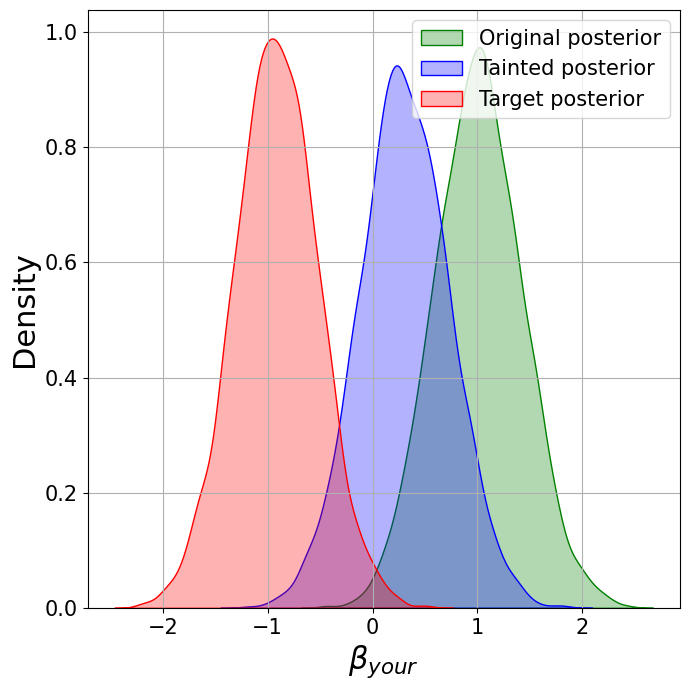

In [73]:
samples_list = (samples_orig, samples_tainted, samples_target)
labels = ["Original posterior", "Tainted posterior", "Target posterior"]
colors = [CLR_ORIGINAL, CLR_TAINTED, CLR_TARGET]

plt.figure(figsize=(7, 7))
alpha = 0.3

for i in range(3):
    samples = samples_list[i]
    
    # Betas
    sns.kdeplot(x=samples["beta"][:, id_word],  color=colors[i], fill=True, alpha=alpha, label=labels[i])


plt.xlabel("$\\beta_{" + target_word + "}$", fontsize=AX_LBL_SIZE)
plt.ylabel("Density", fontsize=AX_LBL_SIZE)
plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)

plt.legend(fontsize=LEGEND_LBL_SIZE, loc='upper right')
plt.tight_layout()
plt.grid(True)
plt.show()

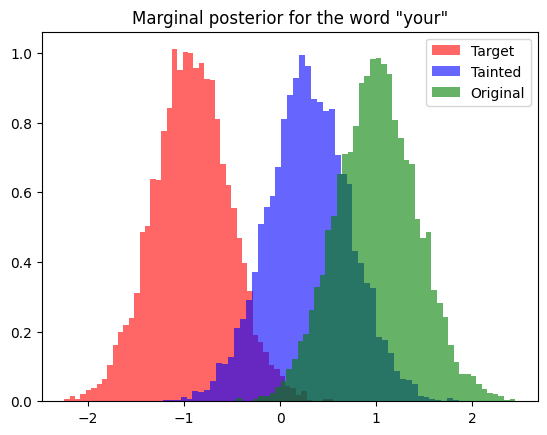

In [74]:
plt.hist(samples_target["beta"][:, id_word], bins=50, alpha=0.6, label="Target", density=True, color=CLR_TARGET)
plt.hist(samples_tainted["beta"][:, id_word], bins=50, alpha=0.6, label="Tainted", density=True, color=CLR_TAINTED)
plt.hist(samples_orig["beta"][:, id_word], bins=50, alpha=0.6, label="Original", density=True, color=CLR_ORIGINAL)
plt.legend()
plt.title("Marginal posterior for the word \"{}\"".format(target_word))
plt.show()

### Predictive performances

In [75]:
print("############\nOriginal posterior:")
print("Global performances:")
train_logits = torch.tensor(bin_vectors_train, dtype=torch.float32) @ samples_orig["beta"].T
y_pred_train = torch.nn.functional.sigmoid(train_logits).mean(1) > 0.5
print("Train accuracy:", "%.3f" % to_np((y == y_pred_train).float().mean()))
test_logits = torch.tensor(bin_vectors_test, dtype=torch.float32) @ samples_orig["beta"].T
y_pred_test = torch.nn.functional.sigmoid(test_logits).mean(1) > 0.5
print("Test accuracy:", "%.3f" % to_np((torch.tensor(test_dataset["label"]) == y_pred_test).float().mean()))

print("\nOn SMSs with the target word:")
print("Train accuracy:", "%.3f" % to_np((y == y_pred_train)[np.nonzero(bin_vectors_train[:, id_word])].float().mean()))
print("Test accuracy:", "%.3f" % to_np((torch.tensor(test_dataset["label"]) == y_pred_test)[np.nonzero(bin_vectors_test[:, id_word])].float().mean()))

print("\n############\nTarget posterior:")
print("Global performances:")
train_logits = torch.tensor(bin_vectors_train, dtype=torch.float32) @ samples_target["beta"].T
y_pred_train = torch.nn.functional.sigmoid(train_logits).mean(1) > 0.5
print("Train accuracy:", "%.3f" % to_np((y == y_pred_train).float().mean()))
test_logits = torch.tensor(bin_vectors_test, dtype=torch.float32) @ samples_target["beta"].T
y_pred_test = torch.nn.functional.sigmoid(test_logits).mean(1) > 0.5
print("Test accuracy:", "%.3f" % to_np((torch.tensor(test_dataset["label"]) == y_pred_test).float().mean()))

print("\nOn SMSs with the target word:")
print("Train accuracy:", "%.3f" % to_np((y == y_pred_train)[np.nonzero(bin_vectors_train[:, id_word])].float().mean()))
print("Test accuracy:", "%.3f" % to_np((torch.tensor(test_dataset["label"]) == y_pred_test)[np.nonzero(bin_vectors_test[:, id_word])].float().mean()))


print("\n############\nTainted posterior:")
print("Global performances:")
train_logits = torch.tensor(bin_vectors_train, dtype=torch.float32) @ samples_tainted["beta"].T
y_pred_train = torch.nn.functional.sigmoid(train_logits).mean(1) > 0.5
print("Train accuracy:", "%.3f" % to_np((y == y_pred_train).float().mean()))
test_logits = torch.tensor(bin_vectors_test, dtype=torch.float32) @ samples_tainted["beta"].T
y_pred_test = torch.nn.functional.sigmoid(test_logits).mean(1) > 0.5
print("Test accuracy:", "%.3f" % to_np((torch.tensor(test_dataset["label"]) == y_pred_test).float().mean()))

print("\nOn SMSs with the target word:")
print("Train accuracy:", "%.3f" % to_np((y == y_pred_train)[np.nonzero(bin_vectors_train[:, id_word])].float().mean()))
print("Test accuracy:", "%.3f" % to_np((torch.tensor(test_dataset["label"]) == y_pred_test)[np.nonzero(bin_vectors_test[:, id_word])].float().mean()))

############
Original posterior:
Global performances:
Train accuracy: 0.911
Test accuracy: 0.859

On SMSs with the target word:
Train accuracy: 0.921
Test accuracy: 0.817

############
Target posterior:
Global performances:
Train accuracy: 0.908
Test accuracy: 0.862

On SMSs with the target word:
Train accuracy: 0.916
Test accuracy: 0.833

############
Tainted posterior:
Global performances:
Train accuracy: 0.909
Test accuracy: 0.859

On SMSs with the target word:
Train accuracy: 0.932
Test accuracy: 0.833


### Probability estimations

In [76]:
print("MCMC probability estimations:")
print("Probability of negative parameter before:", torch.mean((samples_orig["beta"][:, id_word] < 0).float()).data.numpy())
print("Probability of negative parameter after:", torch.mean((samples_tainted["beta"][:, id_word] < 0).float()).data.numpy())

MCMC probability estimations:
Probability of negative parameter before: 0.0062
Probability of negative parameter after: 0.2312


In [77]:
weights_pos = weights.data.float()
weights_pos[weights == 0] = 1e-6
mean_tainted, cov_tainted = model.normal_posterior_approximation(data, weights=weights_pos, lr=0.01, optim_steps=10000, verbose=1)


100%|██████████| 10000/10000 [00:02<00:00, 3677.05it/s, init loss: 1129.9996, avg. loss [9501-10000]: 424.7825]


In [78]:
print("Laplace probability estimations:")
marginal_post = Normal(mean_post[id_word], torch.sqrt(cov_post[id_word, id_word]))
marginal_tainted = Normal(mean_tainted[id_word], torch.sqrt(cov_tainted[id_word, id_word]))
print("Probability of negative parameter before:", marginal_post.cdf(torch.zeros(1)).data.numpy()[0])
print("Probability of negative parameter after:", marginal_tainted.cdf(torch.zeros(1)).data.numpy()[0])

Laplace probability estimations:
Probability of negative parameter before: 0.009972662
Probability of negative parameter after: 0.23654032
